In [30]:
%matplotlib notebook
import numpy as np
import cupy as qp
import operator as op
import time
import matplotlib as mpl
import pandas as pd
from pandas import HDFStore, DataFrame
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Button
from IPython.display import display, HTML
import netCDF4 as nc

xp = np

In [4]:
# common numbers in float32 form to speed up calculations
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

In [6]:
# differential functions
def d_dx(a, dx):
#     ddx = ( a[:-1] - a[1:] )*(np.float32(-1)/dx) 
    return ( a[1:] - a[:-1] )*(np.float32(1)/dx) # ddx
def d_dy(a, dy):
#     ddy = ( a[:,:-1] - a[:,1:] )*(np.float32(-1)/dy)
    return ( a[:,1:] - a[:,:-1] )*(np.float32(1)/dy)


# simple environments or initial conditions


def lingauss(shape, w, cx = 0, cy = 0, theta = 0, cutoff = 0.05, norm = False):#, win = (-2, 2)):
    """returns a 1d gaussian on a 2d array of shape 'shape'"""
    x = np.arange(0, shape[0])#linspace( win[0], win[1], shape[0] )
    y = np.arange(0, shape[1])#linspace( win[0], win[1], shape[1] )
    xx, yy = np.meshgrid(x, y, indexing='ij')
#     xy = (yy, xx)[ax]
    xy = np.cos(theta)*(xx-cx) + np.sin(theta)*(yy-cy) # lin comb of x, y, to rotate gaussian
    h = np.exp( - ( xy*xy ) / (2*w*w) )
    if norm:
        h = h / (np.sqrt(two*np.pi)*w)
    
    h -= cutoff
    h[np.less(h, zero)] = zero
    return (h)



# def planegauss(shape, win=((-2, 2), (-2, 2))):
#     """returns a 2d gaussian array of shape 'shape'"""
#     npx = np.linspace( win[0][0], win[0][1], shape[0] )
#     npy = np.linspace( win[1][0],win[1][1], shape[1] )
#     npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
#     h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) )
#     return (h)

# def planegauss(shape, wx, wy, cutoff = zero, norm = False):
#     """returns a 2d gaussian array of shape 'shape'
#         wx = width in x direction
#         wy = width in y direction
#         cutoff = height to set as zero
#     """
#     npx = np.arange(-shape[0]/2, shape[0]/2)
#     npy = np.arange(-shape[1]/2, shape[1]/2)
#     npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
#     h = np.exp( - ( npxx*npxx/(two*wx*wx) + npyy*npyy/(2*wy*wy) ) )
#     if norm:
#         h = h / (two*np.pi*wx*wy)
#     h[np.less(h, cutoff)] = zero
#     h -= cutoff
#     return (h)

def planegauss(shape, wx, wy, cx=0, cy=0, theta = 0, cutoff = 0.05, norm = False):
    h1 = lingauss(shape, wx, cx=cx, cy=cy, theta = theta, cutoff=cutoff, norm=norm)
    h2 = lingauss(shape, wy, cx=cx, cy=cy, theta = theta + np.pi/2, cutoff=cutoff, norm=norm)
    return h1*h2


def seismic(shape, width, length, cx=0, cy=0, theta=0, cutoff=0.05, norm=False):
    """returns simple seismic initial condition on array with shape 'shape'
        theta - angle from directly east seismic condition points, measured hill-to-valley
        length - length across (long direction)
        width - distance across hill-to-valley (short direction)"""
    offx = width*np.cos(theta)*0.5
    offy = width*np.sin(theta)*0.5
    h1 = planegauss(shape, width/2, length, cx=cx+offx, cy=cy+offy, theta = theta, cutoff=cutoff, norm=norm) # 'hill'
    h2 = -planegauss(shape, width/2, length, cx=cx-offx, cy=cy-offy, theta = theta, cutoff=cutoff, norm=norm) # 'valley'
    
    return h1+h2

<IPython.core.display.Javascript object>


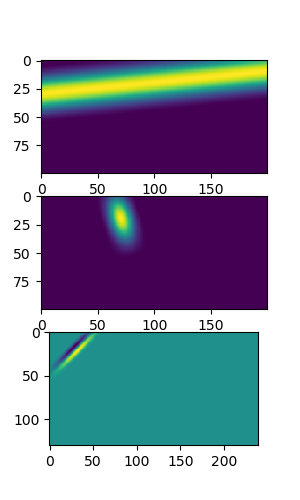

In [7]:
fig = plt.figure(11, figsize=(3, 5))

sub = plt.subplot(311)
plt.imshow(lingauss((100, 200), 10, cx = 30, theta=0.1))

sub = plt.subplot(312)
plt.imshow(planegauss((100, 200), 7, 14, cx = 20, cy = 70, theta=5))

sub = plt.subplot(313)
plt.imshow(seismic((130, 240), 5, 20, cx = 20, cy = 30, theta=np.pi/4))

In [9]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

class State(): # state
    def __init__(self, h, n, u, v, dx, dy, lat, lon):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat
        self.lon = lon
#         self.lats, self.lons = np.meshgrid(self.lat, self.lon)
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
    
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
#         self.calcDt()
        self.dt = np.min((np.min(self.dx), np.min(self.dy)))/(5*self.maxws)
        
        self.coriolis = np.float32(((2*2*np.pi*np.sin(self.lat*np.pi/180))/(24*3600))[:,np.newaxis]) # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
#     def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
#         dx = np.min(self.dx)
#         dy = np.min(self.dy)
#         self.dt = np.min((dx, dy))/(fudge*self.maxws)
props = op.itemgetter('h', 'n', 'u', 'v', 'dx', 'dy', 'lat', 'lon') # for grabbing the elements of a state
# def newstate(state):
#     return State(*(props(vars(state))))


# physics shallow water framework

## Class of objects to hold current state of an ocean grid 

Equations of motion
$$
\begin{align}
\frac{\partial \eta}{\partial t} & =
    -\frac{\partial  }{\partial x} \bigl( \left( \eta + h\right)u \bigr) 
    - \frac{\partial  }{\partial y}  \bigl( \left( \eta + h\right)v \bigr)\\  
\\
\frac{\partial u}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\
 & = +fv +\bigl( \kappa\nabla^{2}u - (u,v)\cdot\vec\nabla u \bigr)  
    - g\frac{\partial \eta}{\partial x} - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\  
& = +fv +\bigl( \kappa\frac{\partial^{2} u}{\partial x^{2}}
           +\kappa\frac{\partial^{2} u}{\partial y^{2}}
           -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial x}
            - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\
\\
\frac{\partial v}{\partial t} & = -fu 
   + \bigl( \kappa\nabla^{2}v - (u,v)\cdot\vec\nabla v \bigr) 
    - g\frac{\partial \eta}{\partial y}
    - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\   
& = -fu+\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}
           +\kappa\frac{\partial^{2} v}{\partial y^{2}}
           -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial y}
           - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\           
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant in time
- $\eta$ is the wave height above the calm ocean height
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$
- $\kappa$ is the viscous damping coefficient across the grid cell boundaries
- $\mu$ is the friction coeffecient


In [11]:
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

def dndt(h, n, u, v, dx, dy) : # for individual vars
# def dndt(state):
    """change in n per timestep, by diff. equations"""
#     h, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy')]
    hx = xp.empty(u.shape, dtype=n.dtype) # to be x (u) momentum array
    hy = xp.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])*p5 # average
    hx[0] = zero#depth[0]#*2-depth[1] # normal flow boundaries/borders
    hx[-1] = zero#depth[-1]#*2-depth[-2] # the water exiting the water on the edge is n+h
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])*p5
    hy[:,0] = zero#depth[:,0]#*2-depth[:,1]
    hy[:,-1] = zero#depth[:,-1]#*2-depth[:,-2]
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
    return ( d_dx(hx, -dx)+d_dy(hy, -dy) )
 # change in x vel. (u) per timestep
    
# countx=0
    
def dudt(h, n, f, u, v, dx, dy, nu, mu=0.3) : # for individual vars
    mu = np.float32(mu)
# def dudt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    dudt = xp.empty(u.shape, dtype=u.dtype) # x accel array
    grav = d_dx(n, -dx/p.g)
    dudt[1:-1] = grav
#     dudt[0] = grav[0]*2-grav[1] # assume outside map wave continues with constant slope
#     dudt[-1] = grav[-1]*2-grav[-2]
    
    
    # coriolis force
    vn = (v[:,1:]+v[:,:-1])*p5 # n shaped v
    
    fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
    fvn = (fn*vn) # product of coriolis and y vel.
    dudt[1:-1] += (fvn[1:]+fvn[:-1])*p5 # coriolis force
    dudt[0] += fvn[0]
    dudt[-1] += fvn[-1]
    
    
    # advection
    
    # advection in x direction
    dudx = d_dx(u, dx)
    
    dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*p5 # advection
#     dudt[0] -= u[0]*dudx[0]
#     dudt[-1] -= u[-1]*dudx[-1]
    
    # advection in y direction
    duy = xp.empty(u.shape, dtype=u.dtype)
    dudy = d_dy(u, dy)
    duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * p5
    duy[:,0] = dudy[:,0]
    duy[:,-1] = dudy[:, -1]
    dudt[1:-1] -= (vn[1:]+vn[:-1])*p5*duy[1:-1] # advection
#     dudt[0] -= vn[0]*duy[0]
#     dudt[-1] -= vn[-1]*duy[-1] # closest to applicable position
    
    
    #attenuation
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * una * np.sqrt(una*una + vna*vna) # attenuation
    dudt[1:-1] -= (attenu[1:] + attenu[:-1])*p5
    
    # viscous term
#     nu = np.float32(1000/dx)

#     ddux = d_dx(dudx, dx)
#     dduy = xp.empty(u.shape, dtype=u.dtype)
#     ddudy = d_dy(duy, dy)
#     dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * p5
#     dduy[:,0] = ddudy[:,0]
#     dduy[:,-1] = ddudy[:, -1]
#     dudt[1:-1] -= nu*(ddux+dduy[1:-1])
    
#     dudt[0] += nu*ddux[0]*dduy[0]
#     dudt[-1] += nu*ddux[-1]*dduy[-1]
    
    dudt[0] = zero
    dudt[-1] = zero # reflective boundaries
    dudt[:,0] = zero
    dudt[:,-1] = zero # reflective boundaries
    return ( dudt )

def dvdt(h, n, f, u, v, dx, dy, nu, mu=0.3) :
    mu = np.float32(mu)
# def dvdt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    #
    dvdt = xp.empty(v.shape, dtype=v.dtype) # x accel array
    grav = d_dy(n, -dy/p.g)
    dvdt[:,1:-1] = grav
#     dvdt[:,0] = grav[:,0]*two-grav[:,1] # assume outside map wave continues with constant slope
#     dvdt[:,-1] = grav[:,-1]*two-grav[:,-2]
    
    
    # coriolis force
    un = (u[1:]+u[:-1])*p5 # n-shaped u
    
    fun = (f*un) # product of coriolis and x vel.
    dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5 # coriolis force
#     dvdt[:,0] += fun[:,0]
#     dvdt[:,-1] += fun[:,-1]
    
    
    
    # advection
    
    # advection in y direction
    dvdy = d_dy(v, dy)
    
    dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*p5 # advection
#     dvdt[:,0] -= v[:,0]*dvdy[:,0]
#     dvdt[:,-1] -= v[:,-1]*dvdy[:,-1]
    
    # advection in x direction
    dvx = xp.empty(v.shape, dtype=v.dtype)
    dvdx = d_dx(v, dx)
    dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * p5
    dvx[0] = dvdx[0]
    dvx[-1] = dvdx[-1]
    dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*p5*dvx[:,1:-1] # advection
#     dvdt[:,0] -= un[:,0]*dvx[:,0]
#     dvdt[:,-1] -= un[:,-1]*dvx[:,-1] # closest to applicable position
    
    
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * vna * np.sqrt(una*una + vna*vna) # attenuation
    dvdt[:,1:-1] -= (attenu[:,1:] + attenu[:,:-1])*p5
    
    
    # viscous term
#     nu = np.float32(dy/1000) # nu given as argument

#     ddvy = d_dy(dvdy, dy)
#     ddvx = xp.empty(v.shape, dtype=v.dtype)
#     ddvdx = d_dx(dvx, dx)
#     ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * p5
#     ddvx[0] = ddvdx[0]
#     ddvx[-1] = ddvdx[-1]
#     dvdt[:,1:-1] -= nu*(ddvy+ddvx[:,1:-1])

#     dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
#     dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]
    
    dvdt[0] = zero
    dvdt[-1] = zero # reflective boundaries
    dvdt[:,0] = zero
    dvdt[:,-1] = zero # reflective boundaries
    return dvdt

In [13]:
def land(h, u, v, coastx): # how to handle land/above water area
    #boundaries / land
#     coastx = xp.less(h, thresh) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = zero
    (u[:-1])[coastx] = zero # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = zero
    (v[:,:-1])[coastx] = zero
    return (u, v)

def border(n, u, v, margwidth=15, alph=0.95):
    alph = np.float32(alph)
    n[0:margwidth] *= alph
    n[-1:-margwidth-1:-1] *= alph
    n[:,0:margwidth] *= alph
    n[:,-1:-margwidth-1:-1] *= alph
    
    u[0:margwidth] *= alph
    u[-1:-margwidth-1:-1] *= alph
    u[:,0:margwidth] *= alph
    u[:,-1:-margwidth-1:-1] *= alph
    
    v[0:margwidth] *= alph
    v[-1:-margwidth-1:-1] *= alph
    v[:,0:margwidth] *= alph
    v[:,-1:-margwidth-1:-1] *= alph
    return n, u, v

In [15]:

def forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta=0, mu=0.3): # forward euler and forward/backward timestep
    """
        beta = 0 forward euler timestep
        beta = 1 forward-backward timestep
    """
    beta = np.float32(beta)
    mu = np.float32(mu)
    
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dudt(h, n, f, u, v, dx, dy, mu) )*dt
    v1 = v + ( beta*dvdt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dvdt(h, n, f, u, v, dx, dy, mu) )*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # handle any land in the simulation
    n1, u1, v1 = border(n1, u1, v1, 15, 0.95)
    return n1, u1, v1

def fbfeedback(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta=1/3, eps=2/3, mu=0.3): # forward backward feedback timestep
    beta = np.float32(beta)
    eps = np.float32(eps)
    mu = np.float32(mu)
    n1g, u1g, v1g = forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, beta, mu) # forward-backward first guess
    #feedback on guess
    
    n1 = n + p5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + p5*(eps*dudt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dudt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dudt(h, n, f, u, v, dx, dy, nu, mu))*dt
    v1 = v + p5*(eps*dvdt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dvdt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dvdt(h, n, f, u, v, dx, dy, nu, mu))*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # how to handle land/coast
    n1, u1, v1 = border(n1, u1, v1, 15, 0.95)
    return n1, u1, v1




def timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, mu): return fbfeedback(h, n, u, v, f, dt, dx, dy, nu, land, coastx, mu) # switch which integrator/timestep is in use
# def timestep(state): return fbfeedback(state, land) # which integrator/timestep is in use

#

In [17]:
def simulate(initstate, t, nttname = '', mu=0.3, colormap='seismic'): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (numpy memmap of n through time) numpy array,
            maxn (the maximum value of n over the duration at each point) numpy array,
            minn (the minimum value of n over the duration at each point) numpy array,
            timemax (the number of seconds until the maximum height at each point) numpy array
    """
    h, n, u, v, f, dx, dy, dt = [qp.asnumpy(initstate.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'coriolis', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    nu = (dx+dy)/1000
    #     state = initstate
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    
#     nshdf = HDFStore('etaevolvestorage')
    
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.memmap('eed_' + nttname, dtype='float32', mode='w+', shape=(itrs,)+n.shape)
    #np.zeros((itrs,)+n.shape, dtype=n.dtype)
#     animframes = np.array([(plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),)])
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
    timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    
    coastx = xp.less(h, landthresh) # where the reflective condition is enforced on the coast
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            n, u, v = timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, mu) # pushes n, u, v one step into the future
            ntt[itr] = n
            
#             nshdf.put(str(itr), DataFrame(n)) # save n value to nshdf with key the iteration number
#             animframes = np.append(animframes, (plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),))
#             np.save('etaevolvestorage', ntt)
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records
            minn = np.min((n, minn), axis=0)
#             timemax[np.greater(n, maxn)] = itr*dt
#             if (itr%ff = 0):
        
    except:
        print('timestep #:' + str(itr))
        ntt.flush()
#         return animframes, maxn, minn, timemax
        raise Exception('error occured in simulate, printed timestep#')
    ntt.flush()
#     nshdf.close()
    print('simulation complete')
    return ntt, maxn, minn#, timemax # return surface height through time and maximum heights

# verification

In [2]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 500 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = np.float32(100)
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.1 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(1)
        plt.clf()
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
        self.simdata = simulate(self.testStart, self.dur)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        self.testFrames = self.simdata[0]
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

EE
ERROR: test_wavespeed (__main__.testWaveSpeed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-2-a746d20cbb98>", line 8, in setUp
    self.dx = np.single(100, dtype=np.float32) # meters
NameError: name 'np' is not defined

ERROR: test_ddx (__main__.testdifferential)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-2-a746d20cbb98>", line 57, in setUp
    self.a = np.arange(144) # test input
NameError: name 'np' is not defined

----------------------------------------------------------------------
Ran 2 tests in 0.001s

FAILED (errors=2)


In [21]:
simpletestcase = {
    'h': 1000*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100), 10, 10, 50, 50),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
simpleState = State(**simpletestcase)

In [23]:
simpleframes, simpleMax = simulate(simpleState, 100)[0:2]#, simpleMax, simpleMin, simpleAT

# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

/home/rrs/anaconda3/envs/shallowwater/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add


simulation complete


In [25]:
fig = plt.figure(25)
mmax = np.max(np.abs(simpleframes))/2
simpleart = [(plt.imshow(simplef, vmin=-mmax, vmax=mmax, cmap='nipy_spectral'),) for simplef in simpleframes[::5]]
anim = animation.ArtistAnimation(fig, simpleart, interval=50, blit=True, repeat_delay=200)
plt.colorbar()
plt.show()
fig = plt.figure(27)
plt.imshow(simpleMax)

# Run Simulation Anywhere

In [47]:
def defstate(latst, laten, lonst, lonen, inlat, inlon, inw, inl, intheta):
    """for creating a simple initial state
    
    latst - first latitude index of sim area
    laten - last latitude index of sim area
    lonst - first longitude index of sim area
    lonen - last longitutde index of sim area
    
    inlat   - latitude  of the initial disturbance
    inlon   - longitude of the initial disturbance
    inw     - width of the        "        "
    inl     - length of the       "        "
    intheta - rotation of the     "        "
    """
    stdict = {}
    latran = (latst, laten) # latitude range map covers
    lonran = (lonst, lonen) # longitude range map covers

    # calculate height of map  11100*lat degrees = meters
    # calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
    # use lon degree size of average latitude
    realsize = (111000*(latran[1]-latran[0]),\
                   111000*(lonran[1]-lonran[0])\
                      *np.cos((latran[1]-latran[0])/2))# h, w of map in meters

    size = (250, 250) # grid size of the map lat, lon


    stdict['dx'] = np.single(realsize[1]/size[1], dtype=np.float32)
    stdict['dy'] = np.single(realsize[0]/size[0], dtype=np.float32)

    # read in bathymetry data
    bathdata = nc.Dataset('../data/bathymetry.nc','r')
    bathlat = bathdata.variables['lat']
    bathlon = bathdata.variables['lon']
    #calculate indexes of bathymetry dataset we need
    bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                            np.argmin(np.abs(bathlat[:]-latran[1])),\
                            size[0], dtype=int)
    bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                            np.argmin(np.abs(bathlon[:]-lonran[1])),\
                            size[1], dtype=int)
    # print(bathlatix, bathlonix)
    stdict['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix])
    stdict['lat'] = np.asarray(bathlat[bathlatix])
    stdict['lon'] = np.asarray(bathlon[bathlonix])

    stdict['n'] = seismic(size, inw, inl, \
                          cx = np.argmin(np.abs(stdict['lat'] - inlat)), \
                          cy = np.argmin(np.abs(stdict['lon'] - inlon)), \
                          theta = intheta)
    stdict['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
    stdict['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)
    
    return State(**stdict)

In [63]:
def sim_render (initstate, time):
    ntt, maxn, minn = simulate(initstate, time)[:3] # run simulation
    
    # render output
    plt.figure()
    mmax = np.max(np.abs((maxn, minn))) # calculate n value of greatest magnitude
    animframes = [(plt.imshow(n[::-1], cmap='seismic', vmax=mmax, vmin=-mmax),) for n in ntt[::10]] # create frames of an animation
    anim = animation.ArtistAnimation(fig, animframes, repeat_delay=200) # display animation
    
    coast = plt.contour(initstate.h[::-1], levels=1, colors='black') # display coast
    xtixks = plt.xticks(np.linspace(0, initstate.h.shape[1], 5),\
               np.round(np.linspace(initstate.lon[0], initstate.lon[-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, initstate.h.shape[0], 5),\
               np.round(np.linspace(initstate.lat[0], initstate.lat[-1], 5), 3))
    
    plt.colorbar()
    plt.show() # show it

In [57]:
def docase(latst, laten, lonst, lonen, inlat, inlon, inw, inl, intheta, time):
    """run and display output of case
    latst - first latitude index of sim area
    laten - last latitude index of sim area
    lonst - first longitude index of sim area
    lonen - last longitutde index of sim area
    
    inlat   - latitude  of the initial disturbance
    inlon   - longitude of the initial disturbance
    inw     - width of the        "        "
    inl     - length of the       "        "
    intheta - rotation of the     "        "
    """
    # define initial state
    initstate = defstate(latst, laten, lonst, lonen, inlat, inlon, inw, inl, intheta)
    
    # plot inital state
    plt.figure()
    ssh = plt.imshow(initstate.n[::-1], cmap='seismic') # display initial SSH
    coast = plt.contour(initstate.h[::-1], levels=1, colors='black') # display coast
    xtixks = plt.xticks(np.linspace(0, initstate.h.shape[1], 5),\
               np.round(np.linspace(initstate.lon[0], initstate.lon[-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, initstate.h.shape[0], 5),\
               np.round(np.linspace(initstate.lat[0], initstate.lat[-1], 5), 3))
    plt.show()
    
    # confirm
    def _sim_render(): sim_render(initstate, time)
    interact_manual(_sim_render)
    
    
    

In [65]:
interact(docase, \
         latst = -1.2, \
         laten = 0.2, \
         lonst = 118.7, \
         lonen = 121, \
         inlat = -0.2, \
         inlon = 119.7, \
         inw = 1, \
         inl = 5, \
         intheta = 0, \
         time = 500)

interactive(children=(FloatSlider(value=-1.2, description='latst', max=1.2, min=-3.5999999999999996), FloatSli…

<function __main__.docase(latst, laten, lonst, lonen, inlat, inlon, inw, inl, intheta, time)>